In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import netCDF4 as nc
import numpy as np
import re
import datetime
from matplotlib.ticker import FixedLocator
from matplotlib.backends.backend_pdf import PdfPages
import mpld3
#mpld3.enable_notebook()
import site
import importlib
import os
import matplotlib.gridspec as gridspecb
from struct import *

In [2]:
# filenames
reccap_region_fname = '/OSM/CBR/OA_GLOBALCABLE/work/BIOS3_forcing/reccap1000pts/params/reccap6ctr05_op.bin'
lat_fname = '/OSM/CBR/OA_GLOBALCABLE/work/BIOS3_forcing/reccap1000pts/params/latdeg_v2ctr05.bin'
lon_fname = '/OSM/CBR/OA_GLOBALCABLE/work/BIOS3_forcing/reccap1000pts/params/londeg_v2ctr05.bin'
cable_fname = '/OSM/CBR/OA_GLOBALCABLE/work/Vanessa/BIOS3_simulations/reccap1000pts_BIOS3/run_190525/outputs/bios_out_cable_1900_2018_LUC.nc'

In [3]:
# get indices, lats and longs for reccap regions
f = open(reccap_region_fname, 'rb')
f1 = open(lat_fname, 'rb')
f2 = open(lat_fname, 'rb')
npt =1000
reccapID=np.zeros(npt)
lat=np.zeros(npt)
lon=np.zeros(npt)
for i in range(npt):
    tmp=f.read(4)
    reccapID[i]=unpack("<f",tmp)[0]
    tmp=f1.read(4)
    lat[i]=unpack("<f",tmp)[0]
    tmp=f2.read(4)
    lon[i]=unpack("<f",tmp)[0]
RECCAPkey=['Tropics','Savanna','WarmTemperate','CoolTemperate','Mediterranean','Sparse_Veg']
RECCAPkey.append('Australia')

In [4]:
# read data from cable output file
f = nc.Dataset(cable_fname)
time = nc.num2date(f.variables['time'][:],
                            f.variables['time'].units)
nc_dims = [dim for dim in f.dimensions]  # list of nc dimensions
var_list = f.variables

In [5]:
# read patchfrac from netcdf file
patchfrac = f.variables['patchfrac'][:,:].filled(fill_value = 0)
#patchfrac = np.repeat(patchfrac[np.newaxis,:,:],f.variables['time'].size,axis=0)

In [6]:
# read patchfrac and variable from netcdf file
vars = ['NPP', 'Rainf', 'Evap', 'Qs', 'Qsb', 'ESoil','TotLivBiomass','TotSoilCarb','TotLittCarb','NBP']
for v in vars:
    mystring = v + '=f.variables["' + v + '"][:,:].filled(fill_value = 0)'
    exec(mystring)
    mystring = v + 'tot = np.sum(patchfrac*' + v + ',1)'
    exec(mystring)

In [7]:
# construct quantities for comparison with BG2013 Fig. 11

NPPmean = NPPtot.mean(axis=0)*12*1e-6*3600*24  # gCm-2d-1
Precipmean = Rainftot.mean(axis=0)*3600*24*365       # mm y-1
SoilEvapmean = ESoiltot.mean(axis=0)*3600*24*365       # mm y-1
Evapmean = Evaptot.mean(axis=0)*3600*24*365       # mm y-1
Runoffmean = (Qstot.mean(axis=0)+Qsbtot.mean(axis=0))*3600*24*365 # mm y-1
NPPgmean = (NPP[:,2,:]*patchfrac[:,2,:]).mean(axis=0)*12*1e-6*3600*24  # gCm-2d-1
Biomassmean = TotLivBiomasstot.mean(axis=0)*10 # tCha-1
SoilCarbmean = TotSoilCarbtot.mean(axis=0)*10 # tCha-1
LitterCarbmean = TotLittCarbtot.mean(axis=0)*10 # tCha-1

SoilEvapFrac = SoilEvapmean / Evapmean
RunoffFrac = Runoffmean / Precipmean
NPPgFrac = NPPgmean / NPPmean

vars = ['Precipmean', 'SoilEvapFrac', 'NPPmean', 'Evapmean', 'RunoffFrac', \
        'NPPgFrac', 'Biomassmean', 'SoilCarbmean','LitterCarbmean']

for v in vars:
    mystring = v + '_reg = np.zeros(7)'
    exec(mystring)
    for i in range(7):
        if (i+1) < 7:
            mystring = v + '_reg[i] = ' + v + '[reccapID==i+1].mean()'
            exec(mystring)
        else:
            mystring = v + '_reg[i] = ' + v + '[:].mean()'
            exec(mystring)

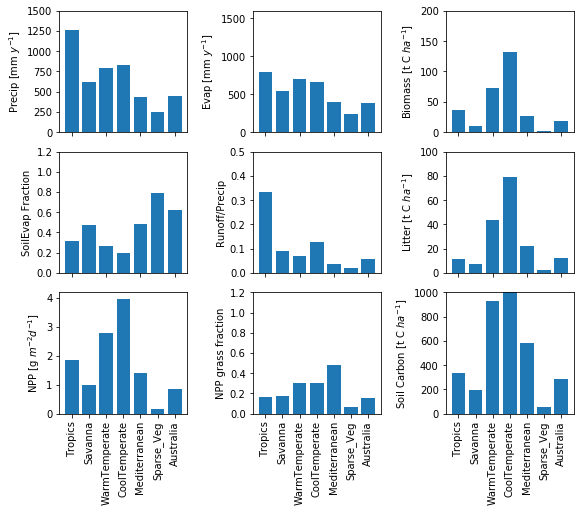

In [24]:
# construct bar plots
vars = ['Precipmean', 'SoilEvapFrac', 'NPPmean', 'Evapmean', 'RunoffFrac','NPPgFrac' , \
       'Biomassmean', 'LitterCarbmean' , 'SoilCarbmean']
varlabels =['Precip [mm $y^{-1}$]', 'SoilEvap Fraction', 'NPP [g $m^{-2}d^{-1}$]', 'Evap [mm $y^{-1}$]', \
            'Runoff/Precip', 'NPP grass fraction' ,\
           'Biomass [t C $ha^{-1}$]', 'Litter [t C $ha^{-1}$]', 'Soil Carbon [t C $ha^{-1}$]' ]
xticklabels = RECCAPkey
ylims =[[0,1500], [0, 1.2], [0, 4.2], [0, 1600], [0, 0.5], [0, 1.2] , \
       [0 , 200], [0, 100], [0 ,1000]]
fig=plt.figure(figsize=(8, 7),constrained_layout=True)
#gs.update(left=0.05, right=0.5, wspace=0.1, hspace =0.1, bottom = 0.3, top = 0.9)
ncols = 3
nrows = 3
sindex=[]
x = np.arange(7)
gs = fig.add_gridspec(ncols=ncols, nrows=nrows)
[sindex.append((j,i)) for i in range(ncols) for j in range(nrows)]
for index, v in enumerate(vars):
    ax = fig.add_subplot(gs[sindex[index]])
    mystring = 'y =' + v +  '_reg[:]'
    exec(mystring)
    plt.bar(x, y)
    if index==2 or index==5 or index==8:
        plt.xticks(x, RECCAPkey)
        plt.xticks(rotation=90)  
    else:
        ax.tick_params(labelbottom=False) 
    ax.set_ylabel(varlabels[index])
    ax.set_ylim(ylims[index])

In [25]:
plot_dir='/OSM/CBR/OA_GLOBALCABLE/work/Vanessa/BIOS3_simulations/reccap1000pts_BIOS3/run_190525/plots'
plot_fname = 'Mean_Fluxes_and_Stocks.pdf'
fig.savefig(os.path.join(plot_dir, plot_fname), bbox_inches='tight',
                    pad_inches=0.1)

In [14]:
# Read variables into dataframe
#def read_nc_cable_reccap(cable_fname):
cable_fname1 = '/OSM/CBR/OA_GLOBALCABLE/work/Vanessa/BIOS3_simulations/reccap1000pts_BIOS3/run_190525/outputs/bios_out_cable_1900_2018_LUC.nc'
f = nc.Dataset(cable_fname1)
time = nc.num2date(f.variables['time'][:],
                        f.variables['time'].units)
nc_dims = [dim for dim in f.dimensions]  # list of nc dimensions

var_list = f.variables
df_reccap = [] # array of data-frames , 1 for each reccap region
df_annual_reccap = [] # array of data-frames , annually aggregated,1 for each reccap region
df = pd.DataFrame()
vars = ['NPP', 'Rainf', 'Evap', 'Qs', 'Qsb', 'ESoil','TotLivBiomass','TotSoilCarb', \
    'TotLittCarb','NBP','Tair','GPP']
patchfrac = f.variables['patchfrac'][:,:].filled(fill_value = 0)
if (f.variables['patchfrac'].dimensions[0] != 'time'):
    patchfrac = np.repeat(patchfrac[np.newaxis,:,:],f.variables['time'].size,axis=0)

for i in np.arange(7):
    for v in vars:
        mystring = v + '=f.variables["' + v + '"][:,:].filled(fill_value = 0)'
        exec(mystring)
        mystring = v + 'tot = np.sum(patchfrac*' + v + ',1)'
        exec(mystring)
        if i == 6:
            mystring = v + ' = ' + v +'tot[:,:].mean(axis=1)'
        else:
            mystring = v + ' = ' + v +'tot[:,reccapID==i+1].mean(axis=1)'
        exec(mystring)
        mystring = 'df[v] = ' + v
        exec(mystring)
        df['dates'] = time
        df = df.set_index('dates')
        df['season']=(df.index.month%12 + 3)//3
        df['year']=df.index.year
        df['day'] = np.floor(df.index.to_julian_date().values-0.5) 
    df['NPP'] = df['NPP'] * 12*1e-6*3600*24*365
    df['NBP'] = df['NBP'] * 12*1e-6*3600*24*365
    df['GPP'] = df['GPP'] * 12*1e-6*3600*24*365
    dfy = df.groupby('year').mean()
    #dfy = dfy.set_index('dates')
    df_reccap.append(df)
    df_annual_reccap.append(dfy)
    #return df_annual_reccap #, df_reccap

In [17]:
cable_fname1 = '/OSM/CBR/OA_GLOBALCABLE/work/Vanessa/BIOS3_simulations/reccap1000pts_BIOS3/run_190525/outputs/bios_out_cable_1900_2018_LUC.nc'
#read_nc_cable_reccap(cable_fname1)
df_annual_reccap_CCxL = df_annual_reccap

#df_annual_reccap_CCxL[6]

In [24]:
cable_fname1 = '/OSM/CBR/OA_GLOBALCABLE/work/Vanessa/BIOS3_simulations/reccap1000pts_BIOS3/run_190525/outputs/bios_out_cable_1900_2018.nc'
df_annual_reccap_CC = df_annual_reccap

In [75]:
cable_luc_fname1 = '/OSM/CBR/OA_GLOBALCABLE/work/Vanessa/BIOS3_simulations/reccap1000pts_BIOS3/run_190525/outputs/bios_out_LUC_1900_2018.nc'
f = nc.Dataset(cable_luc_fname1)
FHarvest = f.variables['HarvProdLoss'][:,:].sum(axis=1)
FClear = f.variables['ClearProdLoss'][:,:].sum(axis=1)
FAg = f.variables['FAg'][:,:]
FLUC = FHarvest + FClear + FAg # gCm-2

[False False False False False False False False False False False False
 False False False False False False False False False  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True]


TypeError: only integer scalar arrays can be converted to a scalar index

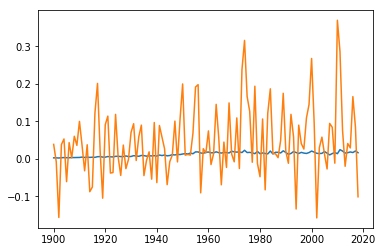

In [92]:
for i in np.arange(7):
    if i == 6:
        df_annual_reccap_CCxL[i]['FLUC'] = FLUC[:,:].mean(axis=1)/1000
    else:
        df_annual_reccap_CCxL[i]['FLUC'] = FLUC[:,reccapID==i+1].mean(axis=1)/1000
df_annual_reccap_CCxL[0]
plt.plot(df_annual_reccap_CCxL[6]['FLUC'])  

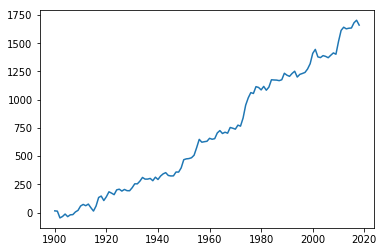

In [26]:
#plt.plot(df_annual_reccap[6].Rainf*3600*24*365)
#plt.plot(df_annual_reccap[6].NBP.cumsum())
#plt.plot(df_annual_reccap[6].NBP*12*1e-6*3600*24*365 * 7.692e6 *1e6/1e15) #PgCy-1) 
#plt.plot(df_annual_reccap[6].Tair - 273.15)
#plt.plot(df_annual_reccap[6].Rainf*3600*24*365)
#plt.plot(df_annual_reccap[6].NBP.cumsum())
#plt.plot(df_annual_reccap[6].NBP)
plt.plot(df_annual_reccap_CC[6].NBP.cumsum())
#plt.plot(df_annual_reccap_CCxL[6].NBP.cumsum())

Text(-0.01, 0.5, 'annual NBP [gC m$^-$$^2$]')

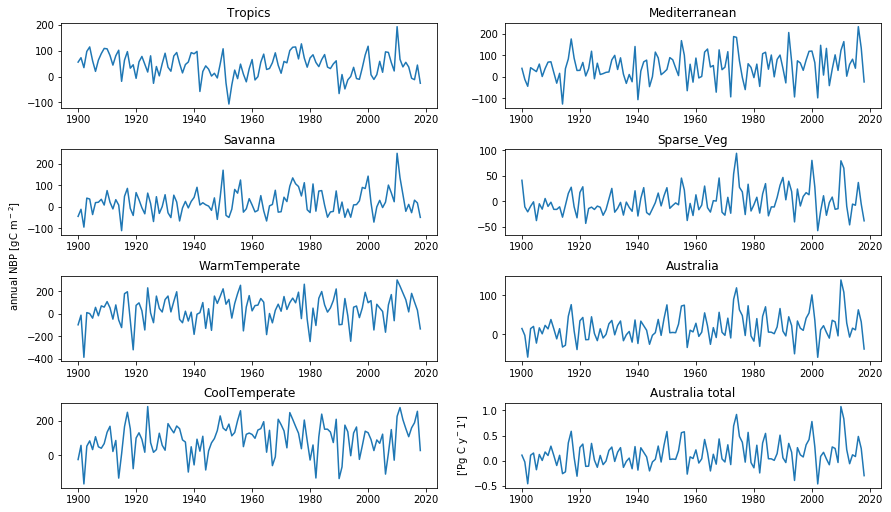

In [22]:
fig=plt.figure(figsize=(12, 7),constrained_layout=True)
#gs.update(left=0.05, right=0.5, wspace=0.1, hspace =0.1, bottom = 0.3, top = 0.9)
ncols = 2
nrows = 4
sindex=[]
x = df_annual_reccap[6].index
gs = fig.add_gridspec(ncols=ncols, nrows=nrows)
[sindex.append((j,i)) for i in range(ncols) for j in range(nrows)]
for index in np.arange(7):
    ax = fig.add_subplot(gs[sindex[index]])
    plt.plot(df_annual_reccap[index].NBP)
    ax.set_title(RECCAPkey[index])
    #plt.rcParams.update({'font.size': 15})
ax = fig.add_subplot(gs[sindex[7]])
plt.plot(df_annual_reccap[6].NBP    * 7.692e6 *1e6/1e15 ) #PgCy-1
ax.set_title(RECCAPkey[6] + ' total')
ax.set_ylabel(['Pg C y$^-1$'])
fig.text(-0.01, .5, 'annual NBP [gC m$^-$$^2$]', ha='center', va='center', rotation='vertical')


In [23]:
plot_dir='/OSM/CBR/OA_GLOBALCABLE/work/Vanessa/BIOS3_simulations/reccap1000pts_BIOS3/run_190525/plots'
plot_fname = 'Annual_NBP_AllDrivers_RECCAP_reg.pdf'
fig.savefig(os.path.join(plot_dir, plot_fname), bbox_inches='tight',
                    pad_inches=0.1)

Text(-0.01, 0.5, 'cumulative NBP [gC m$^-$$^2$]')

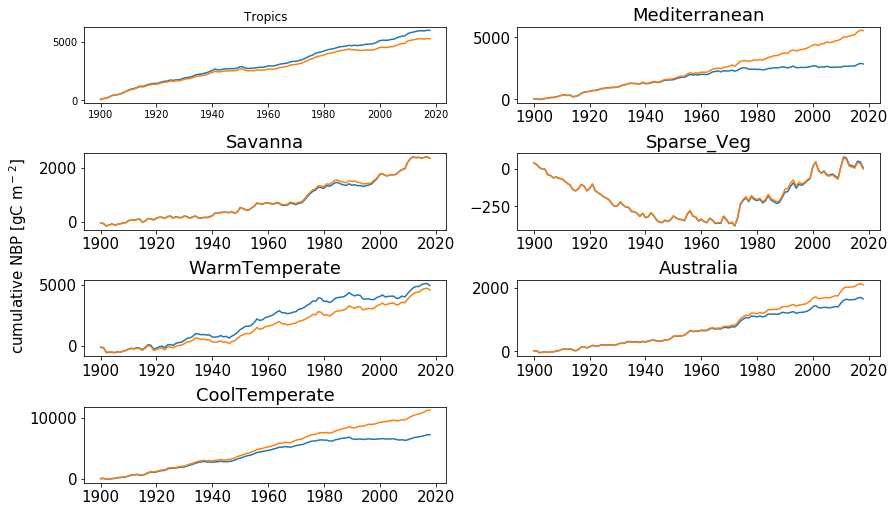

In [27]:
fig=plt.figure(figsize=(12, 7),constrained_layout=True)
#gs.update(left=0.05, right=0.5, wspace=0.1, hspace =0.1, bottom = 0.3, top = 0.9)
ncols = 2
nrows = 4
sindex=[]
x = df_annual_reccap[6].index
gs = fig.add_gridspec(ncols=ncols, nrows=nrows)
[sindex.append((j,i)) for i in range(ncols) for j in range(nrows)]
for index in np.arange(7):
    ax = fig.add_subplot(gs[sindex[index]])
    plt.plot(df_annual_reccap_CC[index].NBP.cumsum())
    plt.plot(df_annual_reccap_CCxL[index].NBP.cumsum())
    ax.set_title(RECCAPkey[index])
    plt.rcParams.update({'font.size': 15})
fig.text(-0.01, .5, 'cumulative NBP [gC m$^-$$^2$]', ha='center', va='center', rotation='vertical')

In [133]:
plot_dir='/OSM/CBR/OA_GLOBALCABLE/work/Vanessa/BIOS3_simulations/reccap1000pts_BIOS3/run_190525/plots'
plot_fname = 'Cum_NBP_AllDrivers_RECCAP_reg.pdf'
fig.savefig(os.path.join(plot_dir, plot_fname), bbox_inches='tight',
                    pad_inches=0.1)

Text(-0.01, 0.5, 'Precip [mm y$^-$$^1$]')

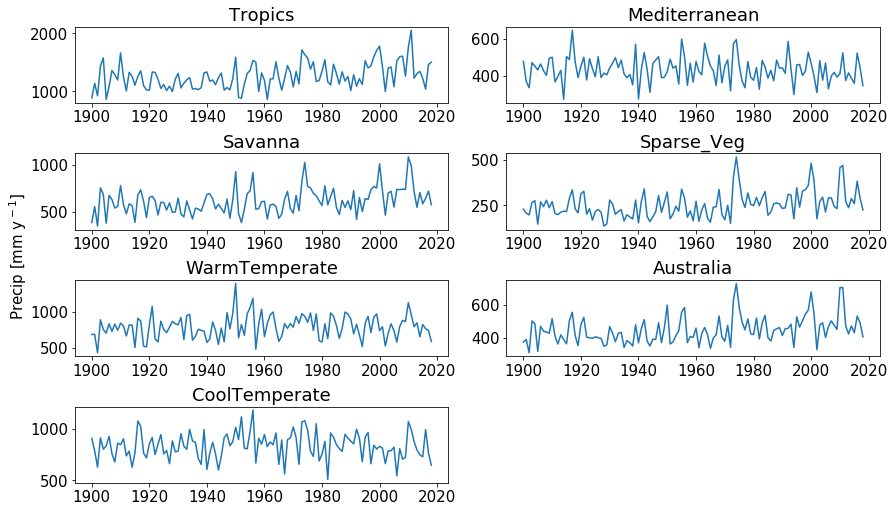

In [134]:
fig=plt.figure(figsize=(12, 7),constrained_layout=True)
#gs.update(left=0.05, right=0.5, wspace=0.1, hspace =0.1, bottom = 0.3, top = 0.9)
ncols = 2
nrows = 4
sindex=[]
x = df_annual_reccap[6].index
gs = fig.add_gridspec(ncols=ncols, nrows=nrows)
[sindex.append((j,i)) for i in range(ncols) for j in range(nrows)]
for index in np.arange(7):
    ax = fig.add_subplot(gs[sindex[index]])
    plt.plot(df_annual_reccap[index].Rainf*3600*24*365)
    ax.set_title(RECCAPkey[index])
    plt.rcParams.update({'font.size': 15})
fig.text(-0.01, .5, 'Precip [mm y$^-$$^1$]', ha='center', va='center', rotation='vertical')

In [135]:
plot_fname = 'Precip_RECCAP_reg.pdf'
fig.savefig(os.path.join(plot_dir, plot_fname), bbox_inches='tight',
                    pad_inches=0.1)

Text(-0.01, 0.5, 'Air Temp [$^o$C]')

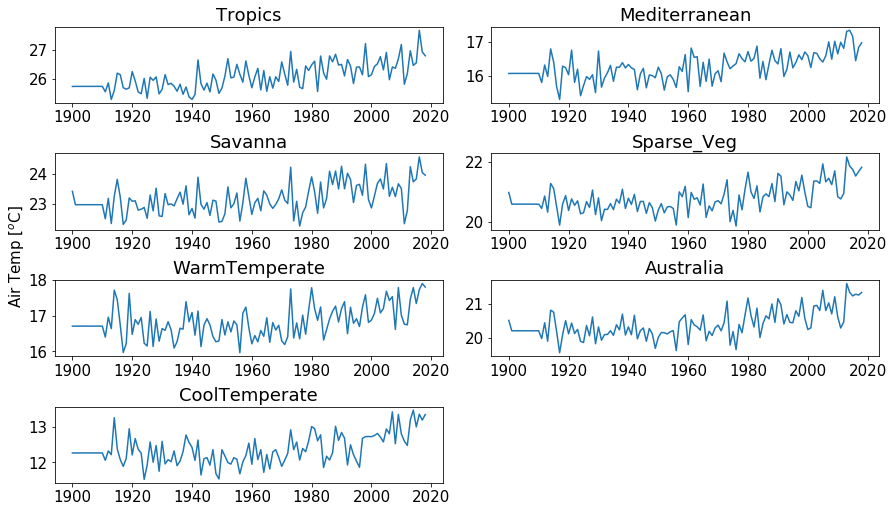

In [136]:
fig=plt.figure(figsize=(12, 7),constrained_layout=True)
#gs.update(left=0.05, right=0.5, wspace=0.1, hspace =0.1, bottom = 0.3, top = 0.9)
ncols = 2
nrows = 4
sindex=[]
x = df_annual_reccap[6].index
gs = fig.add_gridspec(ncols=ncols, nrows=nrows)
[sindex.append((j,i)) for i in range(ncols) for j in range(nrows)]
for index in np.arange(7):
    ax = fig.add_subplot(gs[sindex[index]])
    plt.plot(df_annual_reccap[index].Tair - 273.15)
    ax.set_title(RECCAPkey[index])
    plt.rcParams.update({'font.size': 15})
fig.text(-0.01, .5, 'Air Temp [$^o$C]', ha='center', va='center', rotation='vertical')

In [137]:
plot_fname = 'Ta_RECCAP_reg.pdf'
fig.savefig(os.path.join(plot_dir, plot_fname), bbox_inches='tight',
                    pad_inches=0.1)

In [ ]:
def moving_average(a, n=12) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [ ]:
plot_dir = '/Users/hav014/Data/BIOS3/190221'
plot_fname = 'BIOS3_pools_fluxes_190222.pdf'
fig.savefig(os.path.join(plot_dir, plot_fname), bbox_inches='tight',
                    pad_inches=0.1)

In [ ]:
NPPgmean = NPP[:,2,:]*patchfrac[:,2,:]
NPPgFrac.shape
(NPP[:,2,:]*patchfrac[:,2,:]).mean(axis=0).shape
#RunoffFrac.shape
Biomassmean_reg
#SoilCarbmean_reg
#LitterCarbmean_reg
#NPPgFrac_reg
#RunoffFrac_reg
#NPP_reg

In [ ]:
# continental NPP and bar chart of regional NPP
NPPmean = NPPtot.mean(axis=0)*12*1e-6*3600*24  # gCm-2d-1
x = NPPmean
# annual continental sum
NPP_cont = NPPmean.mean()*365 * 7.692e6 *1e6/1e15 #PgCy-1
print("continental NPP %f PgCy-1" % (NPP_cont))
NPP_reg = np.zeros(7)
for i in range(7):
    if (i+1) < 7:
        NPP_reg[i] = NPPmean[(reccapID==i+1)].mean()
    else:
        NPP_reg[i] = NPPmean[:].mean()
    print(NPP_reg[i])

In [ ]:
NPPmean[reccapID==1].shape
NPPmean.mean()

In [ ]:
patchfrac.shape

In [ ]:
NPP_filled = NPP.filled(fill_value = 0)

In [ ]:
type(NPP_filled)

In [ ]:
NPP_filled.shape

In [ ]:
np.repeat(patchfrac[:,:,np.newaxis],10,axis=2).shape

In [ ]:
10.0**(-1.6)/10**(-1)